# T3 K-MEANS 

En el presente jupyter se realizará el algoritmo k-means desde 0, junto con el procesamiento de datos necesarios para este.

In [1]:
from collections import defaultdict
import math
import pandas as pd
import numpy as np
import random
import seaborn as sn
import datetime as dt
import matplotlib.pyplot as plt

In [2]:
def years_between(d1):
    return d1.days/365

In [3]:
def to_intt(fil):
    return int(fil)

In [4]:
def open_db(nombre):
    frame = pd.read_excel(nombre)
    #transformo la fechainicio y fechatermino en una sola variable cuantificable.
    serie = abs(frame["fechainicio"]-frame["fechatermino"])
    serie = serie.apply(years_between)
    frame["periodo"] = serie
    frame = frame.drop([71348])
    frame["anoinicio"].apply(to_intt)
    # elimino columnas redundantes, las unnamed son solumnas que no se porqué tomó, 
    # si en tu compu no la toma, borralas pls uwu
    frame = frame.drop(["Unnamed: 41", "Unnamed: 42","Unnamed: 43","Unnamed: 44","Unnamed: 45", "Unnamed: 46", 
                        "Unnamed: 47", "siglapart_text", "aux_folio", "diainicio", "mesinicio", "fechae",
                        "diatermino", "mestermino", "anotermino", "numprov", "anoe", "fechatermino","fechainicio", 
                        "circunprov", "numreg", "eleccion", "subpacto_text", "nombrereg", "distrito"], axis=1)
    
    #cambio los nans de estas cosas por un NA, que es como un no se obtuvo esta información
    lista = ["lista", "partido_text", "aux_subpacto", "segvuelta", "alcalde", "pacto_text"]
    for elemento in lista:
        frame[elemento] = frame[elemento].fillna("NA")
    
    columns = frame.columns
    
    #normalizacion de variables tipo int o float
    for column in columns:
        tipo = frame[column].dtype
        if tipo == int or tipo == float:
            frame[column]= (frame[column]-frame[column].mean())/(frame[column].max()- frame[column].min())
        if tipo == object:
            if type(frame.iloc[0][column]) == int:
                frame[column]= (frame[column]-frame[column].mean())/(frame[column].max()- frame[column].min())
    frame = frame.dropna()
    return frame

In [5]:
def hay_nominal(df):
    #nos dice si hay una  variable noiminal en el dataset
    columns = df.columns
    hay = [df[column].dtype == object for column in columns]
    return any(hay)

In [6]:
def dist_nominal(punto1, punto2, columns):
    distintos = 0
    total = len(columns)
    #calcula distancia euclideana entre 2 puntos
    dist = 0
    for columna in columns:
        # si es una fila con tipo entero o floar, la agrego a la suma de la distancia

        if type(punto1[columna]) == str:
            if punto1[columna] != punto2[columna]:
                distintos += 1
    return distintos/total

In [7]:
def dist_euclideana(punto1, punto2, columns):
    dist = 0

    for columna in columns:
        # si es una fila con tipo entero o floar, la agrego a la suma de la distancia
        dist += (punto2[columna]-punto1[columna])**2
    dist = math.sqrt(dist)
    return dist

In [8]:
def define_cluster(fila):
    cluster = fila.idxmin() + 1
    return cluster

In [9]:
def separar_columnas(fila, cols):
    c_eucl= [columna for columna in cols if (type(fila[columna]) == np.float64 ) or type(fila[columna]) == pd.Timestamp]
    c_nom = [columna for columna in cols if type(fila[columna]) == str]
    return c_eucl, c_nom

In [10]:
def K_means(df, k):
   
    # elijo k centros random dentro de mi dataset
    centros = [df.iloc[random.randrange(len(df.index))] for i in range(k)]
    #asigno cluster 0 a todos
    columns = df.columns
    df["clase"] = 0
    p = 0
    nom = hay_nominal(df)
    c_eucl, c_nom = separar_columnas(df.iloc[0], columns)
    if nom:
        eucl = c_eucl + ["nominal"]
        n = "nominal"
    else:
        eucl = c_eucl
        n = None
            
    while(True):
        print("iteracion", p)
        contador = 0
        #dataframe para las distancias a cada centro
        new_df = pd.DataFrame()
        
        i = 0
        for centro in centros:
            #calculo distancia nominal de la forma distintos/ totales y le asigno una columna a este valor
            if nom:
                dist_nominales = df.apply(dist_nominal, axis=1, args= [centro, c_nom])
                df["nominal"] = dist_nominales
            #calculo la distancia a todos los centros incluyendo la distancia nominal sacada antes 
            final = df.apply(dist_euclideana, axis=1, args= [centro, c_eucl])
            new_df[i] = final
            i +=1
        
        clusters = new_df.apply(define_cluster, axis=1)
        df["clase"] = clusters 
        
        for i in range(k):

            frame_by = df[eucl][df["clase"] == i+1] # frame talque su clase o cluster es i+1
            if frame_by.size >0:
                media = frame_by.mean() #calculo la media del cluster
                
                #calculo la diferecia entre el centro anterior y el nuevo
                if diferencia(media, centros[i], 0.00025, c_eucl, n):
                    contador+=1

                frame_by = df[c_nom][df["clase"] == i+1]
                for col in c_nom:
                    media[col] = frame_by[col].value_counts().idxmax()
                centros[i] = media
            else:
                contador+=1
        #print("--------------------------")
        print("el contador es : ",contador)
        print("--------------------------")
        p += 1
        #cuando todas los centros difieran en todas sus cooordenadas por 0.0005 entonces se detiene el algoritmo
        if contador == k:
            print("son iguales")
            return
            
    return
    #calcular las distancias de todos 

In [11]:
def diferencia(media, centro, value, cols, nominal = None):
   
  
    dif = [abs(media[col]- centro[col])<value for col in cols if col != "fechae"]
    if nominal:
        try:
            nom = abs(media["nominal"]- centro["nominal"]) < value
        except:
            nom = media["nominal"]<value
        dif.append(nom)
    return all(dif)

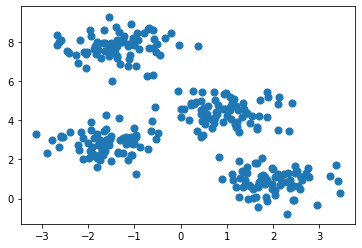

In [12]:
import matplotlib.pyplot as plt

from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

iteracion 0
el contador es :  0
--------------------------
iteracion 1
el contador es :  0
--------------------------
iteracion 2
el contador es :  0
--------------------------
iteracion 3
el contador es :  0
--------------------------
iteracion 4
el contador es :  0
--------------------------
iteracion 5
el contador es :  4
--------------------------
son iguales


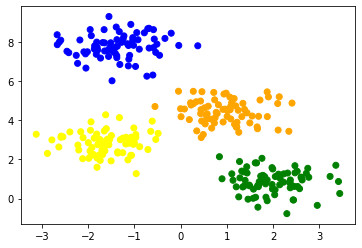

In [13]:
#prueba si funciona con números.
f = pd.DataFrame(X, columns = ["wan", "two"])
f.head()
K_means(f, 4)
colors = {0: "red",1: "blue",2: "green",3: "yellow",4:"orange"}
c = [colors[clase] for clase in list(f["clase"])]
plt.scatter(f["wan"], f["two"], color=c)

In [14]:
frame = open_db("1-Base-de-Datos-Electoral.xlsx/1-Base-de-Datos-Electoral.xlsx")
frame.head()

,vueltae,cargo,tipocargo,periodo,anoinicio,provincia,comuna,municipio,circunsen,nombrecand1,...,alcalde,lista,partido_text,pacto_text,aux_partido,aux_pacto,aux_subpacto,vototot,voto_h,voto_m
0,Primera,Presidente,Eleccion Popular,-0.112451,-0.596689,Aisen,Aisen,Aisen,0.445096,Francisco Errazuriz Talavera,...,NA,NA,Independientes,NA,IndFP,IndFP,NA,-0.011288,-0.011348,-0.012114
1,Primera,Presidente,Eleccion Popular,-0.112451,-0.596689,San Antonio,Algarrobo,Algarrobo,-0.221570,Francisco Errazuriz Talavera,...,NA,NA,Independientes,NA,IndFP,IndFP,NA,-0.016812,-0.017588,-0.016500
2,Primera,Presidente,Eleccion Popular,-0.112451,-0.596689,Melipilla,Alhue,Alhue,-0.166015,Francisco Errazuriz Talavera,...,NA,NA,Independientes,NA,IndFP,IndFP,NA,-0.018358,-0.019252,-0.017794
3,Primera,Presidente,Eleccion Popular,-0.112451,-0.596689,Huasco,Alto Del Carmen,Alto Del Carmen,-0.388237,Francisco Errazuriz Talavera,...,NA,NA,Independientes,NA,IndFP,IndFP,NA,-0.018209,-0.019034,-0.017715
4,Primera,Presidente,Eleccion Popular,-0.112451,-0.596689,Chiloe,Ancud,Ancud,0.389541,Francisco Errazuriz Talavera,...,NA,NA,Independientes,NA,IndFP,IndFP,NA,0.004529,0.005547,0.001217


## Un poco más de procesamiento..

Vemos si queda alguna correlación que no vimos en el analisis de la base de datos 

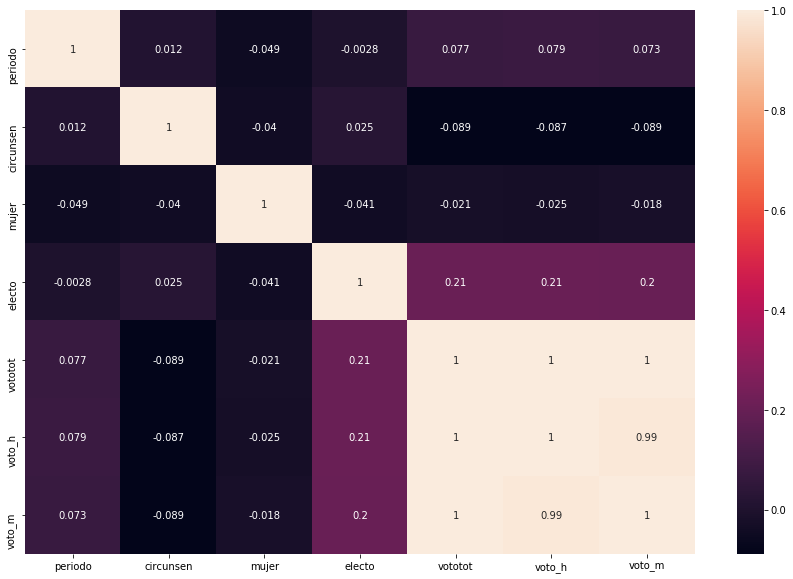

In [15]:
import seaborn as sns 
  
# generating correlation heatmap 
plt.figure(figsize = (15,10))

sns.heatmap(frame.corr(), annot = True) 

# posting correlation heatmap to output console  
plt.show() 

Como es en todas iguales el tipo cargo no influira en nada asique la eliminamos, junto con las variables que 
se ven bastante correlacionadas ya que no agregan información adicional, siempre dejando una de estas, para no
eliminar la información completa

In [16]:
print(frame["tipocargo"].unique().size)
frame = frame.drop(["circunsen", "voto_h", "voto_m", "tipocargo"], axis = 1)

1


Además vemos que el municipio es en la mayoria igual a la comuna, por lo que tampoco agrega mucha información(no se vió en la matriz ya que son variables nominales) y como el atributo segvuelta nos dice que presidente paso a segunda vuelta ese año, pero ademas tenemos los datos vuelta y nombre del presidente, nos conviene borrar esta.

In [17]:
print(frame[frame["comuna"]==frame["municipio"]].size)
print(frame.size)

1433816
1435963


Finalmente, el atributo alcalde nos dice si las elecciones municipales son de alcalde o parlamentario, eso podemos traspasarlo al atributo cargo

In [18]:
frame["cargo"] = np.where((frame["alcalde"] == 0), "Concejal", frame["cargo"])
frame["cargo"] = np.where((frame["alcalde"] == 1), "Alcalde", frame["cargo"])

frame = frame.drop(["municipio", "segvuelta", "alcalde"], axis = 1)

## Aplicación, Análisis y Visualización

Se procederá a separar el dataframe, en mini dataframes separados por las distintas provincias existentes(ya que las comunas son demasiadas) en la base de datos, luego se aplicará el algoritmo a cada uno de estos y se analizarán y visualizarán algunos ejemplos.

In [64]:
def obtener_suma(lista, fram):
    suma = 0
    for clase in lista:
        suma += fram[fram["clase"] == clase].size/17
    return suma

In [65]:
comunas = list(frame["provincia"].unique())
coms = comunas[0:10]
cols = list(frame.columns)
cols.remove("provincia") # ya que todos van a ser de la misma comuna, removemos este atributo ya que no aportará

In [66]:
frames = []
for comuna in coms:
    f = frame[cols][frame["provincia"]== comuna]
    frames.append(f)

In [103]:
elecciones = []
analisis = frames[0]

elecciones.append(analisis[analisis["cargo"] == "Presidente"])
elecciones.append(analisis[(analisis["cargo"] == "Senador")  | (analisis["cargo"] == "Diputado")])
elecciones.append(analisis[(analisis["cargo"] == "Concejal")  | (analisis["cargo"] == "Alcalde")])


In [104]:
for f in elecciones:
    K_means(f, 5)

/home/pancha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pancha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


iteracion 0


/home/pancha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


el contador es :  0
--------------------------
iteracion 1
el contador es :  1
--------------------------
iteracion 2
el contador es :  5
--------------------------
son iguales
iteracion 0
el contador es :  0
--------------------------
iteracion 1
el contador es :  1
--------------------------
iteracion 2
el contador es :  5
--------------------------
son iguales
iteracion 0
el contador es :  0
--------------------------
iteracion 1
el contador es :  2
--------------------------
iteracion 2
el contador es :  5
--------------------------
son iguales


In [105]:
def cantidad(elecciones, provincia):
    print(provincia)
    electos_presi = elecciones[0][elecciones[0]["electo"] > 0.7]
    electos_par = elecciones[1][elecciones[1]["electo"] > 0.7]
    electos_muni = elecciones[2][elecciones[2]["electo"] > 0.7]
    print("---------------presidente-------------------")
    print(electos_presi.size/17)
    print(obtener_suma(list(electos_presi["clase"].unique()), elecciones[0]))
    print("---------------parlamento-------------------")
    print(electos_par.size/17)
    print(obtener_suma(list(electos_par["clase"].unique()), elecciones[1]))
    print("---------------municipal-------------------")
    print(electos_muni.size/17)
    print(obtener_suma(list(electos_muni["clase"].unique()), elecciones[2]))

In [106]:
def analisis(elecciones):
    presi = elecciones[0][elecciones[0]["electo"] > 0.7]
    par = elecciones[1][elecciones[1]["electo"] > 0.7]
    muni = elecciones[2][elecciones[2]["electo"] > 0.7]
    print("---------------presidente-------------------")
    print(presi["partido_text"].value_counts())
    print("---------------parlamento-------------------")
    print(par["partido_text"].value_counts())
    print("---------------municipales-------------------")
    print(muni["partido_text"].value_counts())

### Análisis Exhaustivo de la primera provincia Aisen

In [107]:
presi = elecciones[0][elecciones[0]["electo"] > 0.7]
par = elecciones[1][elecciones[1]["electo"] > 0.7]
muni = elecciones[2][elecciones[2]["electo"] > 0.7]

In [108]:
presi

,vueltae,cargo,periodo,anoinicio,comuna,nombrecand1,mujer,electo,lista,partido_text,pacto_text,aux_partido,aux_pacto,aux_subpacto,vototot,clase,nominal
670,Primera,Presidente,-0.112451,-0.596689,Aisen,Patricio Aylwin Azocar,-0.187448,0.726936,NA,Partido Democrata Cristiano,NA,DC,ConcertacionNM,NA,0.025562,1,0.5
712,Primera,Presidente,-0.112451,-0.596689,Cisnes,Patricio Aylwin Azocar,-0.187448,0.726936,NA,Partido Democrata Cristiano,NA,DC,ConcertacionNM,NA,-0.012247,1,0.4
765,Primera,Presidente,-0.112451,-0.596689,Guaitecas,Patricio Aylwin Azocar,-0.187448,0.726936,NA,Partido Democrata Cristiano,NA,DC,ConcertacionNM,NA,-0.018535,1,0.5
1675,Primera,Presidente,0.387891,-0.430023,Aisen,Eduardo Frei Ruiz-Tagle,-0.187448,0.726936,NA,Partido Democrata Cristiano,NA,DC,ConcertacionNM,NA,0.027266,1,0.5
1718,Primera,Presidente,0.387891,-0.430023,Cisnes,Eduardo Frei Ruiz-Tagle,-0.187448,0.726936,NA,Partido Democrata Cristiano,NA,DC,ConcertacionNM,NA,-0.010897,1,0.4
1771,Primera,Presidente,0.387891,-0.430023,Guaitecas,Eduardo Frei Ruiz-Tagle,-0.187448,0.726936,NA,Partido Democrata Cristiano,NA,DC,ConcertacionNM,NA,-0.017361,1,0.5
5409,Segunda,Presidente,0.387207,-0.180023,Aisen,Ricardo Lagos Escobar,-0.187448,0.726936,NA,Partido Por la Democracia,NA,PPD,ConcertacionNM,NA,0.027061,1,0.6
5454,Segunda,Presidente,0.387207,-0.180023,Cisnes,Ricardo Lagos Escobar,-0.187448,0.726936,NA,Partido Por la Democracia,NA,PPD,ConcertacionNM,NA,-0.012024,1,0.5
5508,Segunda,Presidente,0.387207,-0.180023,Guaitecas,Ricardo Lagos Escobar,-0.187448,0.726936,NA,Partido Por la Democracia,NA,PPD,ConcertacionNM,NA,-0.017920,1,0.6
7408,Segunda,Presidente,-0.112451,0.0699773,Aisen,Michelle Bachelet Jeria,0.812552,0.726936,NA,Partido Socialista de Chile,NA,PS,ConcertacionNM,NA,0.028030,2,0.6


Se puede ver que entre los electos, se encuentran 2 cluster diferentes, donde la diferencia entre un cluster y otro radica en el sexo del postulante más el año de comienzo.

In [109]:
par

,vueltae,cargo,periodo,anoinicio,comuna,nombrecand1,mujer,electo,lista,partido_text,pacto_text,aux_partido,aux_pacto,aux_subpacto,vototot,clase,nominal
15851,Unica,Diputado,-0.112451,-0.596689,Aisen,Antonio Horvath Kiss,-0.187448,0.726936,B,Independientes Lista B,Democracia y Progreso,IndAlianzaDer,AlianzaDer,NA,0.000607,3,0.7
15853,Unica,Diputado,-0.112451,-0.596689,Cisnes,Antonio Horvath Kiss,-0.187448,0.726936,B,Independientes Lista B,Democracia y Progreso,IndAlianzaDer,AlianzaDer,NA,-0.013263,3,0.6
15856,Unica,Diputado,-0.112451,-0.596689,Guaitecas,Antonio Horvath Kiss,-0.187448,0.726936,B,Independientes Lista B,Democracia y Progreso,IndAlianzaDer,AlianzaDer,NA,-0.018097,3,0.7
15861,Unica,Diputado,-0.112451,-0.596689,Aisen,Baldemar Carrasco Munoz,-0.187448,0.726936,A,Partido Democrata Cristiano,Concertacion por la Democracia,DC,ConcertacionNM,NA,0.003402,3,0.6
15863,Unica,Diputado,-0.112451,-0.596689,Cisnes,Baldemar Carrasco Munoz,-0.187448,0.726936,A,Partido Democrata Cristiano,Concertacion por la Democracia,DC,ConcertacionNM,NA,-0.017073,3,0.5
15866,Unica,Diputado,-0.112451,-0.596689,Guaitecas,Baldemar Carrasco Munoz,-0.187448,0.726936,A,Partido Democrata Cristiano,Concertacion por la Democracia,DC,ConcertacionNM,NA,-0.018842,3,0.6
17948,Unica,Diputado,-0.112451,-0.430023,Aisen,Hector Zambrano Opazo,-0.187448,0.726936,D,Partido Democrata Cristiano,Concertacion de Partidos por la Democracia,DC,ConcertacionNM,NA,0.002815,3,0.6
17950,Unica,Diputado,-0.112451,-0.430023,Cisnes,Hector Zambrano Opazo,-0.187448,0.726936,D,Partido Democrata Cristiano,Concertacion de Partidos por la Democracia,DC,ConcertacionNM,NA,-0.015424,3,0.5
17953,Unica,Diputado,-0.112451,-0.430023,Guaitecas,Hector Zambrano Opazo,-0.187448,0.726936,D,Partido Democrata Cristiano,Concertacion de Partidos por la Democracia,DC,ConcertacionNM,NA,-0.018498,3,0.6
17968,Unica,Diputado,-0.112451,-0.430023,Aisen,Valentin Solis Cabezas,-0.187448,0.726936,B,Partido Union de Centro Centro,Union por el Progreso de Chile,UCC,AlianzaDer,NA,-0.003408,3,0.8


Acá se divide en 3 clusters, donde 2 de ellos apuntan al cargo de senador y el cluster restante al de diputado, concentrandose en ambos clusters una gran cantidad de partidos de derecha o independientes con partidos auxiliares de derecha como la Alianza.

In [110]:
muni

,vueltae,cargo,periodo,anoinicio,comuna,nombrecand1,mujer,electo,lista,partido_text,pacto_text,aux_partido,aux_pacto,aux_subpacto,vototot,clase,nominal
51114,Unica,Alcalde,-0.063854,-0.513356,Aisen,Eduardo Laibe Vera,-0.187448,0.726936,A,Partido Democrata Cristiano,Concertacion por la Democracia,DC,ConcertacionNM,NA,0.003252,2,0.6
51115,Unica,Concejal,-0.063854,-0.513356,Aisen,Roman Hernandez Saez,-0.187448,0.726936,A,Partido Democrata Cristiano,Concertacion por la Democracia,DC,ConcertacionNM,NA,-0.015927,2,0.5
51117,Unica,Concejal,-0.063854,-0.513356,Aisen,Pedro Puchi Cardenas,-0.187448,0.726936,A,Partido Socialista de Chile,Concertacion por la Democracia,PS,ConcertacionNM,NA,-0.016355,2,0.5
51118,Unica,Concejal,-0.063854,-0.513356,Aisen,Sergio Cardenas Ruiz,-0.187448,0.726936,A,Partido Socialista de Chile,Concertacion por la Democracia,PS,ConcertacionNM,NA,-0.012769,2,0.5
51126,Unica,Concejal,-0.063854,-0.513356,Aisen,Enrique Frigolett Rodriguez,-0.187448,0.726936,D,Renovacion Nacional,Participación y Progreso,RN,AlianzaDer,NA,-0.003864,2,0.6
51127,Unica,Concejal,-0.063854,-0.513356,Aisen,Rigoberto Trujillo Cardenas,-0.187448,0.726936,D,Renovacion Nacional,Participación y Progreso,RN,AlianzaDer,NA,-0.018060,2,0.6
51150,Unica,Concejal,-0.063854,-0.513356,Cisnes,Hugo Altamirano Altamirano,-0.187448,0.726936,A,Partido Democrata Cristiano,Concertacion por la Democracia,DC,ConcertacionNM,NA,-0.018358,2,0.6
51153,Unica,Concejal,-0.063854,-0.513356,Cisnes,Guido Gomez Munoz,-0.187448,0.726936,A,Partido Socialista de Chile,Concertacion por la Democracia,PS,ConcertacionNM,NA,-0.017930,2,0.6
51157,Unica,Alcalde,-0.063854,-0.513356,Cisnes,Benjamin Ortuzar Aguirre,-0.187448,0.726936,D,Independientes Lista D,Participación y Progreso,IndAlianzaDer,AlianzaDer,NA,-0.017641,2,0.7
51159,Unica,Concejal,-0.063854,-0.513356,Cisnes,Dagoberto Riffo Diaz,-0.187448,0.726936,D,Renovacion Nacional,Participación y Progreso,RN,AlianzaDer,NA,-0.019476,2,0.7


Vemos que tambien se dividen en diferentes cluster, donde la diferencia radica en el sexo y tambien en los partidos politicos, la mayoría del cluster donde se encuentran las mujeres, también pertenecen al partido de Renovación nacional o tienen pacto con la Alianza

In [111]:
cantidad(elecciones, comunas[0])
analisis(elecciones)

Aisen
---------------presidente-------------------
15.0
24.0
---------------parlamento-------------------
66.0
93.0
---------------municipal-------------------
96.0
96.0
---------------presidente-------------------
Partido Democrata Cristiano    6
Partido Socialista de Chile    3
Renovacion Nacional            3
Partido Por la Democracia      3
Name: partido_text, dtype: int64
---------------parlamento-------------------
Partido Democrata Cristiano       15
Partido Por la Democracia         15
Renovacion Nacional               15
Independientes Lista B             6
Union Democrata Independiente      6
Independiente                      3
Partido Union de Centro Centro     3
Independientes Lista C             3
Name: partido_text, dtype: int64
---------------municipales-------------------
Renovacion Nacional                           31
Partido Democrata Cristiano                   15
Partido Socialista de Chile                   13
Independientes Lista C                         7
Unio

Primero que nada, vemos que los diferentes cluster que se encuentran, clasifican correctamente a las personas electas, aveces haciendo distinción entre el sexo y los años que ejercieron su posición.

#### Presidencia

Acá vemos que los clasificados con las clases de electos, tienen la misma cantidad, además, analisando los atributos, podemos ver que en esta ciudad han sido electros presidentes principalmente de partidos de centro/izquierda, en su mayoría hombres.

#### Parlamentarios

En esta eleccion, se ve un poco más disperso en cuanto a partidos políticos, sin embargo, predomina más el centro/izquierda y los partidos independientes.

#### Municipales

También se está un poco más disperso en cuanto a partidos, aunque en su mayoría son de la derecha y los demás están repatidos entre centro/izquierda e independientes, diría que es más que nada mitad y mitad

## Otras provincias

In [77]:
elec = []

for i in range(len(frames)-1):
    lista = []
    ana = frames[i+1]
    lista.append(ana[ana["cargo"] == "Presidente"])
    lista.append(ana[(ana["cargo"] == "Senador")  | (ana["cargo"] == "Diputado")])
    lista.append(ana[(ana["cargo"] == "Concejal")  | (ana["cargo"] == "Alcalde")])
    elec.append(lista)

In [78]:
for elemento in elec:
    for f in elemento:
        K_means(f, 5)

/home/pancha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/pancha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


iteracion 0


/home/pancha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


el contador es :  0
--------------------------
iteracion 1
el contador es :  0
--------------------------
iteracion 2
el contador es :  3
--------------------------
iteracion 3
el contador es :  3
--------------------------
iteracion 4
el contador es :  5
--------------------------
son iguales
iteracion 0
el contador es :  0
--------------------------
iteracion 1
el contador es :  0
--------------------------
iteracion 2
el contador es :  1
--------------------------
iteracion 3
el contador es :  5
--------------------------
son iguales
iteracion 0
el contador es :  0
--------------------------
iteracion 1
el contador es :  0
--------------------------
iteracion 2
el contador es :  5
--------------------------
son iguales
iteracion 0
el contador es :  0
--------------------------
iteracion 1
el contador es :  0
--------------------------
iteracion 2
el contador es :  1
--------------------------
iteracion 3
el contador es :  3
--------------------------
iteracion 4
el contador es :  5


In [79]:
for i in range(len(elec)):
    cantidad(elec[i], comunas[i+1])
    analisis(elec[i])

San Antonio
---------------presidente-------------------
30.0
48.0
---------------parlamento-------------------
132.0
132.0
---------------municipal-------------------
156.0
156.0
---------------presidente-------------------
Partido Democrata Cristiano    12
Partido Socialista de Chile     6
Renovacion Nacional             6
Partido Por la Democracia       6
Name: partido_text, dtype: int64
---------------parlamento-------------------
Partido Democrata Cristiano        36
Union Democrata Independiente      24
Partido Por la Democracia          24
Partido Radical SocialDemocrata    12
Independientes Lista B             12
Independientes Lista C             12
Independientes                      6
Renovacion Nacional                 6
Name: partido_text, dtype: int64
---------------municipales-------------------
Partido Democrata Cristiano                   35
Renovacion Nacional                           29
Union Democrata Independiente                 18
Partido Radical SocialDemocrata

#### A continuación se analizarán alguna de las otras provincias de manera menos minuiciosa

#### San antonio
* Tiene preferencia por presidentes de centro/izquierda en su gran mayoría
* En el parlamento, también se encuentra preferencia por estos partidos, pero aparecen más partidos de derecha.
* Municipales, está mucho más dispersa, con grandes cantidades entre centro/izquierda, derecha y partidos independientes

#### Melipilla
* * Tiene preferencia por presidentes de centro/izquierda en su gran mayoría.
* En el parlamento, vemos un gran porcentaje de electos de la UDI, mientras que el resto abarca patidos de centro y centro/izquierda.
* Municipales, está mucho más dispersa, con grandes cantidades entre centro/izquierda, derecha y partidos independientes

#### Chiloé
* Vemos que en general en las 3 elecciones predominan los partidos de centro/izquierda, frente a los partidos de derecha

#### Biobio
* Presidencia, predomina centro/izquierda
* Parlamento, Udi tiene gran porcentaje de eleccion
* Municipales, partido democrata cristiano y de centro/izquierda predominan

En general, podríamos decir que en la mayoría de las provincias se prefiere un presidente de centro/izquierda mientras que para elecciones de parlamentarios y municipales está más bien disperso y equilibrado entre partidos de centro/derecha, centro/izquierda e independientes

### Visualización

Se presentará la visualización para un tipo de elecciones, pero ejectuando el mismo comando en las otras, se puede ver que funciona de la misma manera

In [275]:
def vis(df):
    colores= ["green", "purple", "red"]
    new = df.groupby(["clase"])
    groups = df["clase"].unique()
    a = collections.defaultdict(lambda: 'blue')
    electos_clus = list(df["clase"][df["electo"] > 0.7].unique())
    for i in electos_clus:
        a[i] = random.choice(colores)
    for group in groups:
        frame = new.get_group(group)
        columns = list(frame.columns)
        columns.remove("vueltae")
        columns.remove("cargo")
        columns.remove("clase")
        columns.remove("nominal")
        columns.remove("nombrecand1")
        fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20,10))
        fig.suptitle("Cluster "+ str(group), fontsize=16)
        axes_list = [item for sublist in axes for item in sublist] 
        for col in columns:
            g = frame[col].value_counts()
            if g.size>1 and len(axes_list)>0:
                ax = axes_list.pop(0)
                x = list(g.index)
                if type(x[0]) == float or type(x[0]) == int:
                    x = [round(value, 3) for value in x]
                y = list(g.values)
                xx = range(len(y))
                ax.title.set_text(col)
                ax.bar(xx, y, width=0.8, align='center', color = a[group])
                ax.set_xticks(xx)
                ax.set_xticklabels(x, rotation='vertical')

        
    return

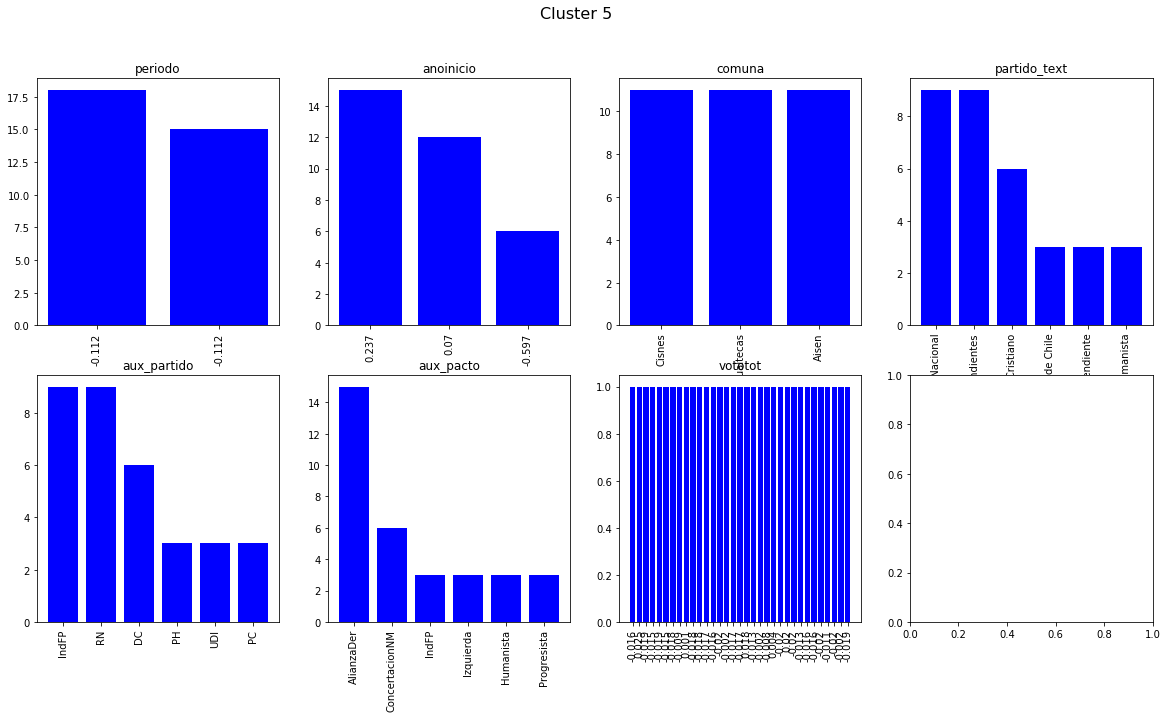

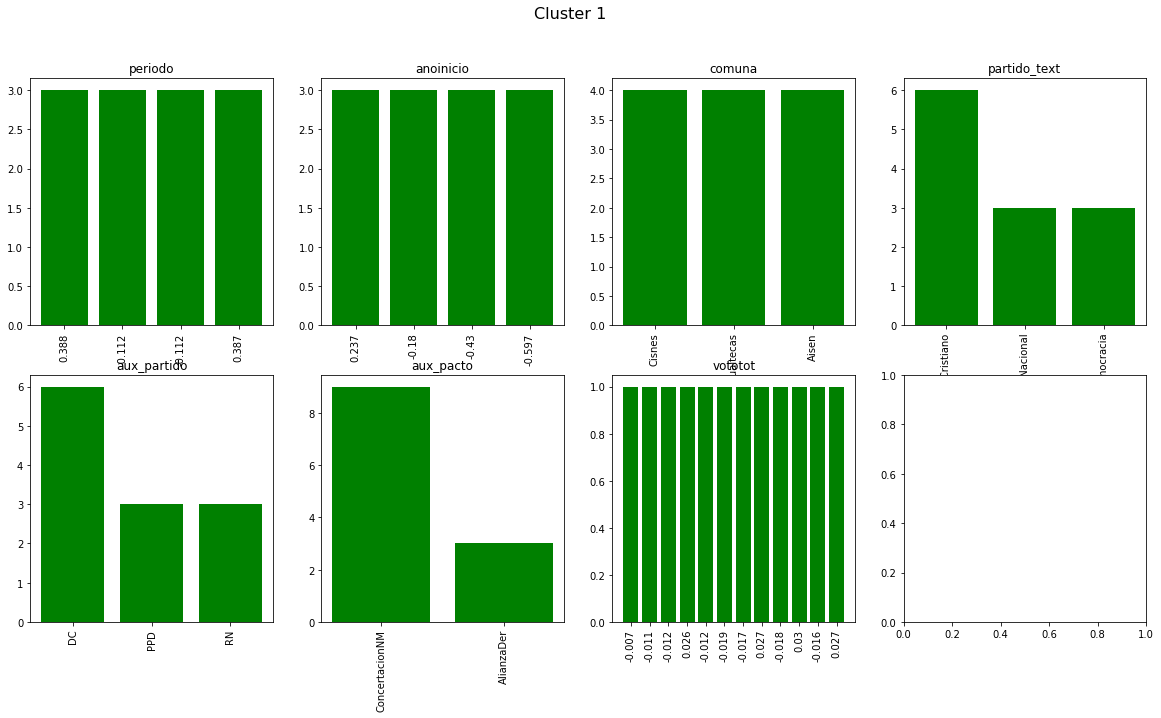

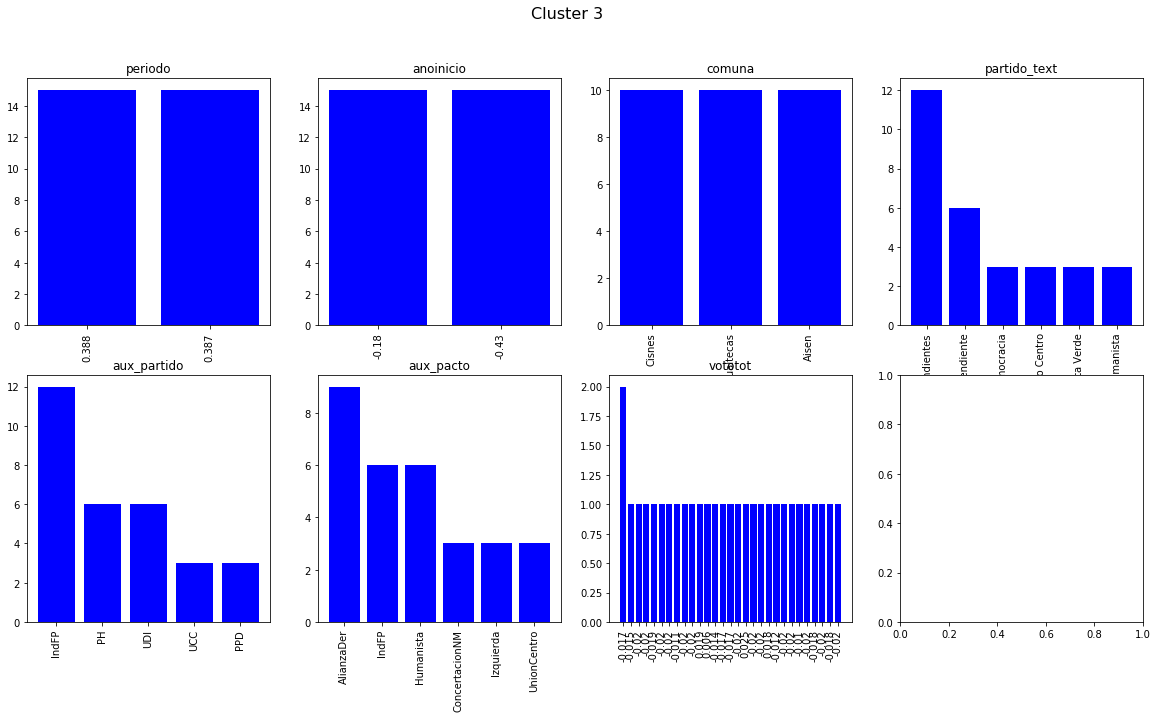

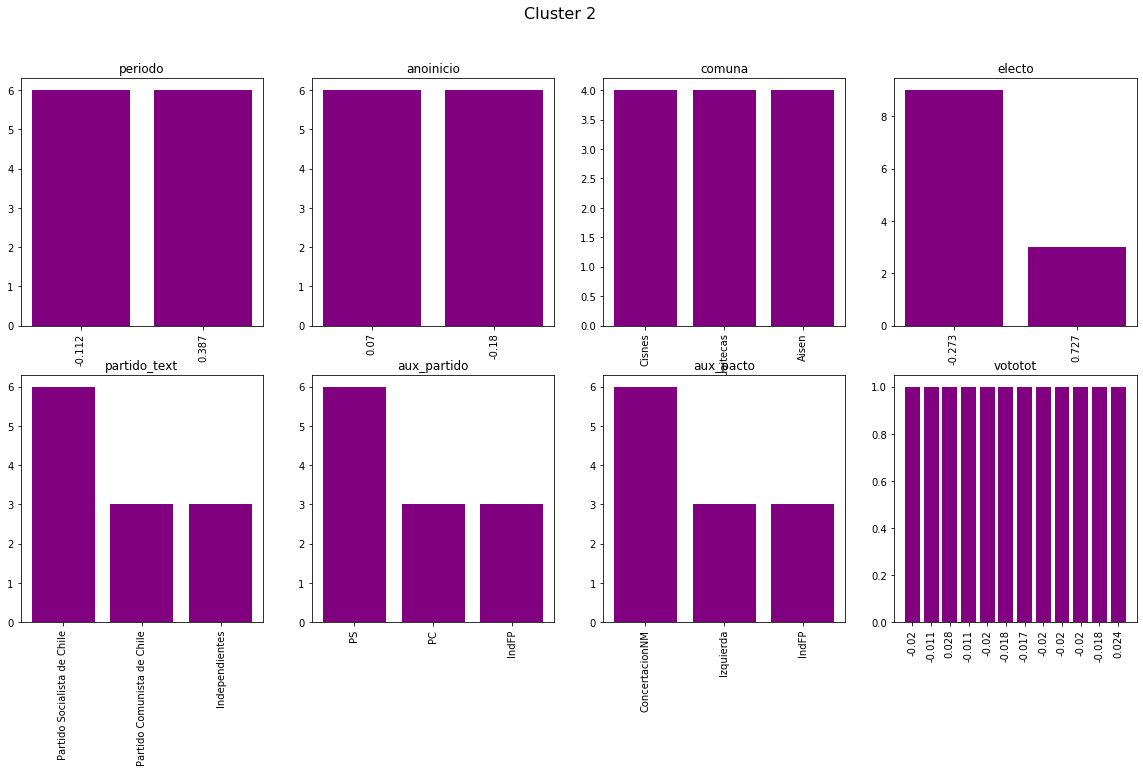

In [276]:
vis(elecciones[0])

En los gráficos podemos ver que se puede inferir la misma información sacada antes, los graficos distintos de azul, son los cluster clasificados como electos(la mayoría), y vemos que para la provincia de aisen, en las elecciones de presidentes, se ha tenido una gran preferencia por partidos de tipo centro/izquierda, con partidos auxiliares y pactos del mismo tipo.